# Import Files

In [9]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [8]:
with open('models/residual_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('models/trend_model.pkl', 'rb') as f:
    t_model = pickle.load(f)

# Analysis of Residual Model

From the forecasted residuals, even though the residuals going to 0 is a design of an AR model with small coefficients and no intercept, we see that it does not accurately reflect reality.

Moreover, an AR(15) model is overly complicated and can be simplified much further. Hence, a different method should be used.

In [68]:
def get_residual_data(residual_model, forecast_t:int=0) -> np.array:
    result = residual_model.forecast(forecast_t)
    return result.values

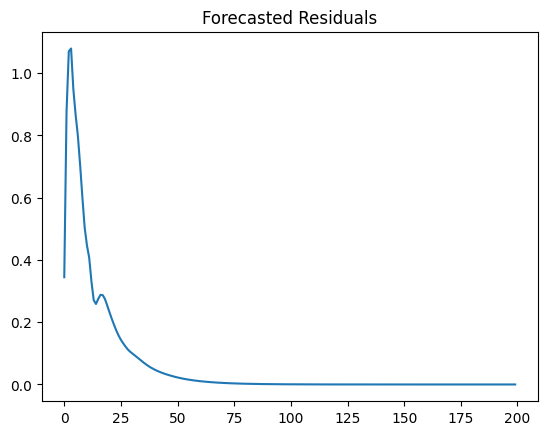

In [69]:
forecast_resid = get_residual_data(r_model, 200)
plt.plot(forecast_resid)
plt.title("Forecasted Residuals")
plt.show()

# Analyze Model Results

If we remove the residual model and plot out information regarding the residuals, we see that there is a strong partial correlation at lag 1.

In [ ]:
class TemperatureModel:
    def __init__(self, trend_model, residual_model, forecast_t:int, training_periods:int=60753, latest_temp:float=19.4078):
        self.forecast_t = forecast_t
        self.latest_temp = latest_temp
        self.training_periods = training_periods
        self.trend_model = trend_model
        self.residual_model = residual_model
        
    def get_seasonal_data(self, forecast_t:int, training_periods:int=60753) -> np.array:
        t = forecast_t + training_periods
        time = np.arange(training_periods+1, t+1)
        omega = 2*np.pi/365
        ot = omega*time
        
        a = 3.4997*np.cos(ot)
        b = 2.7523*np.sin(ot)
        c = -0.3661*np.cos(2*ot)
        d = -0.1726*np.sin(2*ot)
        result = a+b+c+d
        return result
    
    def get_trend_data(self, forecast_t:int=0, latest_temp:float=19.4078, fitted_val:bool=False) -> np.array:
        standardized_forecasts = self.trend_model.fittedvalues if fitted_val else self.trend_model.forecast(forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        forecasts = standardized_forecasts*TREND_STD + TREND_MEAN
        result = latest_temp + np.cumsum(forecasts)
        return result.values
    
    def get_fitted_temps(self) -> np.array:
        self.past_trend = self.get_trend_data(fitted_val=True) 
        self.past_seasonal = self.get_seasonal_data(self.training_periods, 0)
        self.fitted_temp = self.past_seasonal[1:] + self.past_trend #Indexed to account for lag in Trend model
    
    def pipeline(self) -> np.array:
        self.seasonal = self.get_seasonal_data(self.forecast_t, self.training_periods)
        self.trend = self.get_trend_data(self.forecast_t, self.latest_temp)
        self.forecast = self.seasonal + self.trend

In [64]:
forecast = TemperatureModel(t_model, r_model, 30)
forecast.get_fitted_temps()
hist = pd.read_csv('dataset/historical_temp.csv')
residuals = hist['T_AVG'][1:].values - forecast.fitted_temp

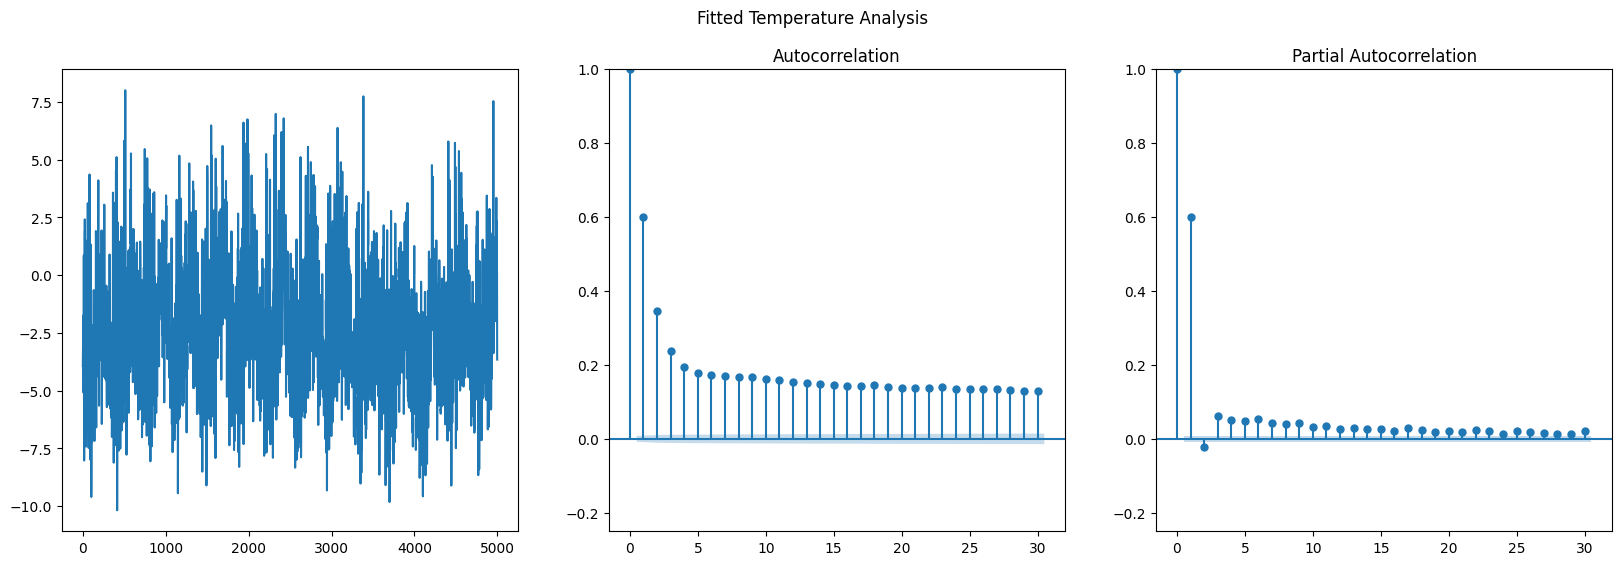

In [66]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('Fitted Temperature Analysis')

axes[0].plot(residuals[-5000:])

plot_acf(residuals, lags=30, ax=axes[1])
axes[1].set_ylim([-0.25, 1])

plot_pacf(residuals, lags=30, ax=axes[2])
axes[2].set_ylim([-0.25, 1])

plt.show()

# Mean-Reverting Process
The best model to describe temperature data is a mean-reverting process, or more specifically the Ornstein-Uhlenbeck process.
$$dT_t = \kappa(\mu - T_t)dt + \sigma{dW_t}$$

If we follow the same steps to solve the Vasicek Mean-Reverting Process by letting $X_t = e^{\kappa{t}}T_t$

$$dX_t = f_{t}dt + f_{T}dT + \frac{1}{2}f_{TT}(dT)^2$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}dT + 0$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}(\kappa(\mu - T_t)dt + \sigma{dW_t})$$
$$dX_t = \kappa\mu{e^{\kappa{t}}}dt + \sigma{e^{\kappa{t}}}{dW_t}$$

Now, instead of setting the origin to be 0, we will use $s$ to model a reversion to a changing mean temperature by assuming that temperature follows a Markov chain:
$$X_t - X_s = \kappa{\int_{s}^{t}e^{\kappa{u}}}\mu{du} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

We also need to change $du$ to $d\bar{T}$ by letting $\bar{T} = \kappa{\mu}$:
$$X_t - X_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

Afterwards, we can further simplify to:
$$e^{\kappa{t}}T_t - e^{\kappa{s}}T_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$e^{\kappa{t}}T_t = e^{\kappa{s}}T_s + {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$T_t = e^{\kappa(s-t)}T_s + {\int_{s}^{t}e^{\kappa(u-t)}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa(u-t)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + \bar{T_t} - \bar{T_s}e^{-\kappa(t-s)}+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$

Therefore,
$$E[T_t] = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)}